# GSA workflow tutorial
Fanny Sarrazin (fanny.sarrazin@inrae.fr), Andres Peñuela (apenuela@uco.es); 2022-11-02

The goal of this session is to give a flavour of Sensitivity Analysis by application  of several methods to a simple rainfall-runoff model.

The uncertain inputs subject to SA are the model parameters. The aim is to assess the impact of the uncertainty in these parameters on the model's ability to reproduce streamflow observations, as measured by different
performance metrics:
- the Root Mean Squared Error (RMSE)
- the volumetric bias (BIAS)

The analysis will be conducted using the [SAFE(R/Python/Matlab) Toolbox](https://safetoolbox.github.io) (Pianosi et al., 2015).

Programme:

 1. **Model setup and One-At-a-Time Sensitivity Analysis (OAT)**:
    Load the data and get confident with the rainfall-runoff model (Hymod)

 2. **Visual and qualitative Global Sensitivity Analysis (GSA)**:
    Perform Monte Carlo simulations (forward propagation of uncertainty), i.e.
    sample the model parameters within their ranges and run the model to
    obtain an ensemble of runoff predictions. Use a visual and qualitative
    GSA method for a preliminary assessment of sensitivity (scatterplots).

 3. **Regional Sensitivity Analysis (RSA)**:
    Use RSA to formally assess the effect of parameter variations on the model 
    outputs.
    (Young et al., 1978; Spear and Hornberger, 1980; Saltelli et al., 2008)
    
 4. **Regional Sensitivity Analysis based on grouping**: 
    Use RSA based on grouping to assess the output sensitivity without 
    specifying a single threshold on output values.
    (Wagener et al., 2001)

Throughout the session, we will also examine the impact of several key choices on SA results: <br> 
- the threshold value for RSA 
- the output (scalar) metric
- the sample size for the Monte Carlo simulations
- the parameter ranges
- the SA method

Further investigation of these choices can be found in Noacco et al.
(2019), and a general discussion on the topic is also provided in
Pianosi et al. (2016) and in Wagener and Pianosi (2019). The choice of
sample size is more specifically discussed in Sarrazin et al. (2016).

**Hymod model**:

We will use the Hymod (Boyle 2001; Wagener et al. 2001) model, which
produces a time series of streamflow predictions as output. The model is
composed of a soil moisture accounting routine, and a flow routing routine,
which in its turn is composed of a fast and a slow routing pathway.
The model is applied to the Leaf catchment in the USA (Sorooshian et al.,
1983).

![hymod_model](images/hymod_model.png)

Hymod includes 5 parameters:
- **Sm**: the maximum soil moisture (mm) (soil moisture)
- **beta**: the exponent in the soil moisture (-) (soil moisture)
- **alfa**: the partition coefficient (-) (routing)
- **Rs**: the slow reservoir coefficient (-) (routing)
- **Rf**: the fast reservoir coefficient (-) (routing)

The model is applied to the Leaf catchment in the USA (Sorooshian et al., 1983).

![leaf_catchment](images/leaf_catchment.png)

The model forcing input data are:
- 1-year daily observations of rainfall (R) [column 1 in LeafCatch.txt]
- 1-year daily observations potential evaporation (PE) [column 2 in the file
LeafCatch.txt]

We will also used output measurements:
- 1-year daily observations of streamflow (Q) [column 3 in LeafCatch.txt]

For this application, we can use the following ranges of feasible variations of the parameters:
- SM ∈ [0,400] (mm)
- beta ∈ [0,2] (-)
- alfa ∈ [0,1] (-)
- RS ∈ [0,0.1] (-)
- RF ∈ [0.1,1] (-)



## Import libraries

In [1]:
from __future__ import division, absolute_import, print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatRangeSlider, IntRangeSlider
import scipy.stats as st

import warnings
warnings.filterwarnings('ignore') # to hide warning messages

#sys.path.append("../../SAFE-python")

# Module to perform Regional Sensitivity Analysis:
import safepython.RSA_thres as RSA_tr
# Module to perform Regional Sensitivity Analysis based on grouping:
import safepython.RSA_groups as RSA_gp
# Module to visualize the results:
import safepython.plot_functions as pf
# Module to execute the model
from safepython.model_execution import model_execution
# Functions to perform the input sampling
from safepython.sampling import AAT_sampling, AAT_sampling_extend
# Function to calculate RMSE:
from safepython.util import aggregate_boot, RMSE
# Module that simulates the HyMod model:
from safepython import HyMod

# Import the additional function BIAS in the BIAS.py module
from BIAS import BIAS

## 1. Model setup and One-At-a-Time Sensitivity Analysis

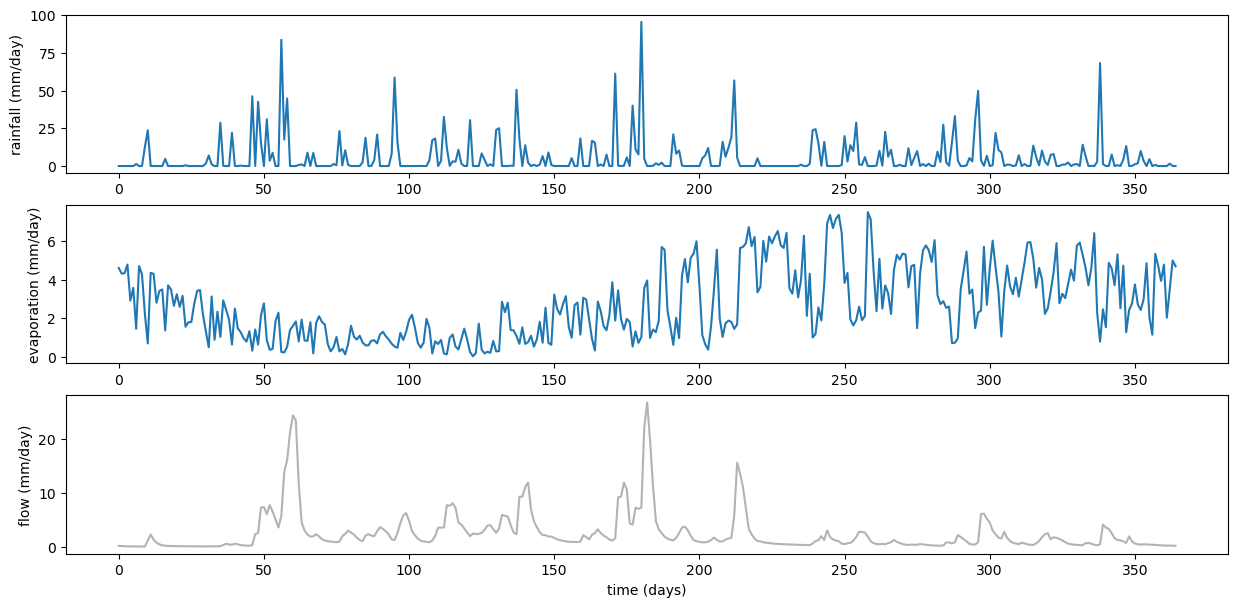

In [2]:
# Specify the directory where the data are stored 
#mydir = '../../SAFE-python/data'

# Load data and plot the data (one year of daily observations of rainfall, 
# potential evaporation and flow):

# Load data:
data = np.genfromtxt('LeafCatch.txt', comments='%')
rain = data[0:365, 0] # select the first year of data
evap = data[0:365, 1]
flow = data[0:365, 2]
warmup = 30 # Model warmup period (days)

# Plot data:
plt.figure(figsize=[15,7])
plt.subplot(311); plt.plot(rain); plt.ylabel('rainfall (mm/day)')
plt.subplot(312); plt.plot(evap); plt.ylabel('evaporation (mm/day)')
plt.subplot(313); plt.plot(flow, color=[0.7, 0.7, 0.7]); plt.ylabel('flow (mm/day)')
plt.xlabel('time (days)')
plt.show()

In [3]:
# Set the parameters to some tentative values, run the model and plot the 
# resulting streamflow time series:

def oat_function(Sm = 200, beta = 0.5, alpha = 0.7, Rs = 0.05, Rf = 0.6):
    # Set a tentative parameterization:
    param = np.array([Sm, beta, alpha, Rs, Rf]) # Sm (mm), beta (-), alfa (-), Rs (-), Rf (-)
    # Run simulation:
    flow_sim, _, _ = HyMod.hymod_sim(param, rain, evap)
    # Plot results:
    plt.figure(figsize=[15,3])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # observed flow
    plt.plot(flow_sim, 'k') # simulated flow
    plt.ylabel('flow (mm/day)')
    plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.show()
    
interact(oat_function, Sm = (0, 400, 1), beta = (0, 2, 0.1), alpha = (0,1,0.1), Rs = (0,0.1,0.01), Rf = (0.1,1,0.1));

interactive(children=(IntSlider(value=200, description='Sm', max=400), FloatSlider(value=0.5, description='bet…

**To do**:
One-At-a-Time (OAT) effect: change one parameter (e.g. alfa) and repeat the previous steps.
- What is the effect of varying this parameter (and the others)?
- Which parameter controls which characteristic (timing, peak, recession phase, etc.) of the simulated flow time series?
- Which parameters seem to mostly influence the output?
- What are the pros and cons of OAT sensitivity analysis?

## 2. Visual and qualitative Global Sensitivity Analysis
 In this section, we run Monte Carlo (MC) simulations of the model against a certain number of input (parameter) samples. Each model simulation provides a times series of runoff predictions. To measure the accuracy of each of these times series with respect to observations, we define two aggregate output metrics to be used for the subsequent steps:
- the Root Mean Squared Error (RMSE) of the streamflow predictions
- the volumetric Bias (BIAS) of the streamflow predictions

Input (parameter) sampling (this involves a number of choices that will be  assessed and revised later on):

In [3]:
# Define input variability space
X_Labels = ['Sm', 'beta', 'alfa', 'Rs', 'Rf'] # Name of parameters (used to customize plots)
M = len(X_Labels) # Number of parameters
distr_fun = st.uniform # Parameter distributions
xmin = [0,   0, 0, 0.0, 0.1] # Parameter ranges (lower bound)
xmax = [400, 2, 1, 0.1, 1.0] # Parameter ranges (upper bound)
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Choose sampling strategy and size:
samp_strat = 'lhs' # sampling strategy
# options:
# 'lhs' = Latin Hypercube sampling
# 'rsu' = Random uniform sampling
N = 150 # Choose the number of samples

# Perform sampling:
X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

# If you want to see what the sample 'X' looks like:
print(X[0:10, :]) # Print to screen the first 10 samples

[[1.56649636e+02 1.63813271e+00 2.36642236e-01 5.91406807e-02
  9.53125912e-01]
 [3.78924140e+02 1.48683146e+00 2.25605683e-01 4.24861822e-02
  4.98472286e-01]
 [1.55555474e+01 1.78752747e+00 4.80019185e-01 1.73206700e-02
  8.00163887e-01]
 [2.35093476e+02 9.35173504e-01 4.40287195e-01 1.93916159e-02
  6.56684730e-01]
 [3.74438392e+02 1.98766954e+00 4.63398433e-01 7.05205856e-02
  7.09799641e-01]
 [1.04348202e+02 1.02798285e+00 5.21321565e-01 6.70091859e-03
  1.07549828e-01]
 [1.93647228e+02 5.69923835e-02 3.34840919e-02 7.51277452e-02
  3.16553872e-01]
 [2.60223029e+01 7.27402268e-01 4.51812814e-01 2.54609017e-02
  2.33494834e-01]
 [1.27417269e+02 4.36878985e-01 8.96578612e-01 5.60646873e-02
  5.98964012e-01]
 [3.42782931e+02 1.97760058e+00 5.41854668e-01 2.70468789e-03
  8.87231170e-01]]


Execute the model against all the input samples in 'X':

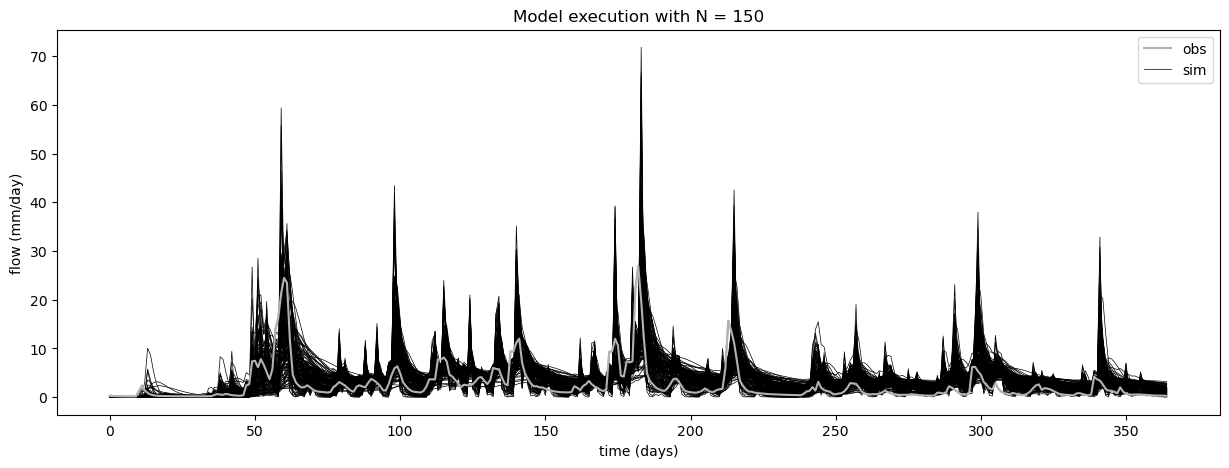

In [4]:
QQ = model_execution(HyMod.hymod_sim, X, rain, evap)

# Plot Monte Carlo (MC) simulations results and compare with data:
plt.figure(figsize=[15,5])
plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
plt.plot(np.transpose(QQ), 'k', linewidth = 0.5)
plt.plot(flow, color=[0.7, 0.7, 0.7])
plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
plt.legend(['obs', 'sim'])
plt.title("Model execution with N = %d" % N)
plt.show()

### Let's do it more interactive!

In [5]:
def sampling_function(samp_strat='lhs', N = 150):
    
    # Perform sampling:
    sampling_function.X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
    
    # Execute the model against all the input samples in 'X':
    sampling_function.QQ = model_execution(HyMod.hymod_sim, sampling_function.X, rain, evap)

    # Plot Monte Carlo (MC) simulations results and compare with data:
    plt.figure(figsize=[15,5])
    plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
    plt.plot(np.transpose(sampling_function.QQ), 'k',linewidth = 0.5);
    plt.plot(flow, color=[0.7, 0.7, 0.7])
    plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
    plt.legend(['obs', 'sim'])
    plt.title("Model execution with N = %d" % N)
    plt.show()

sampling_interact = interact(sampling_function,samp_strat=['lhs','rsu'], N = (10,300,10),continuous_update=False)

interactive(children=(Dropdown(description='samp_strat', options=('lhs', 'rsu'), value='lhs'), IntSlider(value…

Here we retreive the values selected with the sliders in the interactive figure above

In [6]:
samp_strat = sampling_interact.widget.kwargs["samp_strat"]
N          = sampling_interact.widget.kwargs["N"]
QQ = sampling_function.QQ
X = sampling_function.X
# print the selected sample size
print(N)

290


Aggregate time series into various scalar output metric(s):

In [7]:
YY = np.nan * np.ones((N, 2))
YY[:, 0] = RMSE(QQ[:, warmup:365], flow[warmup:365])
YY[:, 1] = BIAS(QQ[:, warmup:365], flow[warmup:365])

# If you want to see what the samples in 'YY' looks like:
print(YY.shape) # Check the shape of 'YY'
print(YY[0:10, :]) # Print to screen the first 10 samples

(290, 2)
[[3.71392174 1.52941952]
 [2.79893563 0.71520781]
 [4.00005118 0.91825845]
 [2.25564557 0.61660681]
 [2.88569957 0.45718901]
 [2.92446999 0.92542257]
 [3.95409869 1.43219253]
 [3.23595829 0.24249085]
 [4.1925365  1.53627869]
 [4.08512645 0.85101008]]


Let's plot the scatter plots of the input (parameter) samples against their corresponding RMSE or BIAS (you can choose one or the other interactively)  

In [8]:
def output_metric_interact(metric):
    if metric == 'RMSE': 
        i = 0
    elif metric == 'BIAS': 
        i = 1
    
    Y = YY[:, i]; 
    Y_Label = metric

    # Scatter plots of the output metric against input samples:
    plt.figure(figsize=[15,3])
    pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels)
    plt.title("Scatter plots with N = %d" % N + ', ' + Y_Label, loc='right')
    plt.show()
  
aggregate_interact = interact(output_metric_interact, metric = ['RMSE', 'BIAS'])

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), Output()), _dom_…

**To do**:
- From these scatter plots, which parameter would you say is most influential? Why?
- Are there parameters that are not influential at all?

## 3. Regional Sensitivity Analysis
In this section, we formally assess the sensitivity of the output metrics (RMSE and BIAS) to the model parameters through the Regional Sensitivity Analysis (RSA) method.

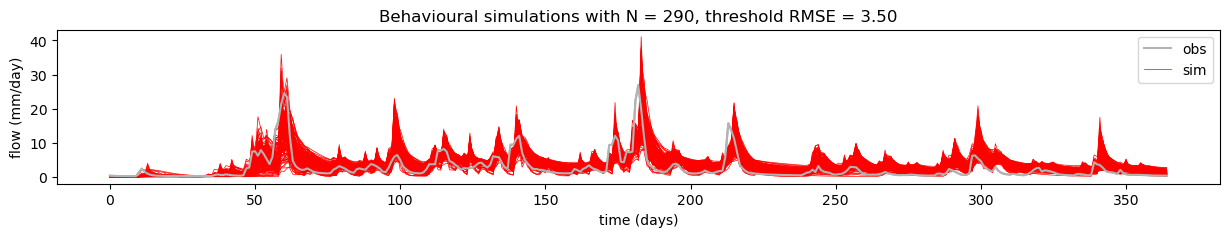

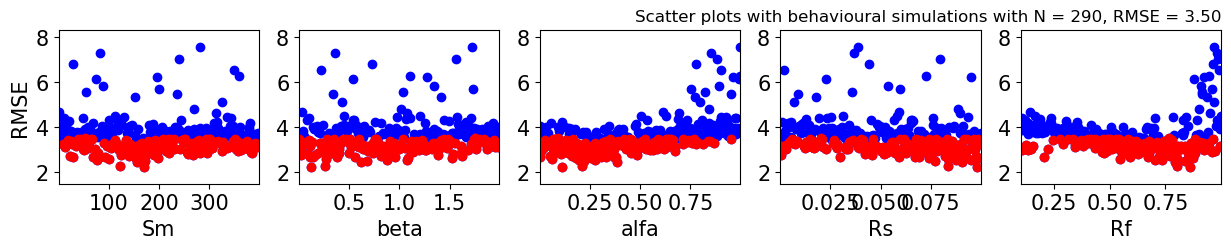

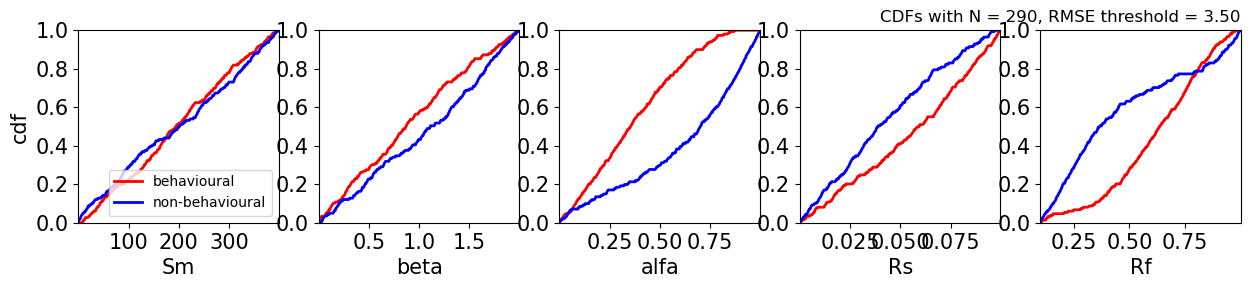

Value of the KS statistics between the two CDFs of the inputs: [0.09286496 0.1794945  0.44062069 0.24399067 0.41567899]


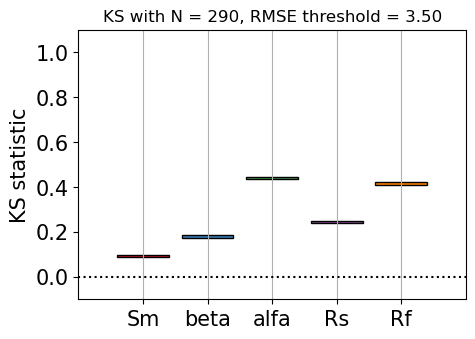

In [9]:
def RSA_function(metric = 'RMSE',threshold = 3.5):
    
    # Select the index of the output of interest:
    if metric == 'RMSE': 
        i = 0
    elif metric == 'BIAS': # for BIAS threshold higher than 2.5 you get an error
        i = 1
    
    # Extract output of interest:
    Y = YY[:, i]
    
    # Check that there are values below the threshold, otherwise plot a warning message
    if np.all(np.logical_not(Y<threshold)):
        print('Cannot find any output value below the threshold! Try increasing the threshold value')
    
    # Check that there are value above the threshold, otherwise plot a warning message
    elif np.all(Y<threshold):
        print('Cannot find any output value above the threshold! Try reducing the threshold value')
    
    # Perform RSA if there are values both below and above the threshold:
    else:
        Y_Label = metric

        # Use the function RSA_indices_thres to split into behavioural (Y<threshold)
        # and non-behavioural (Y>threshold) sample:
        mvd, _, _, idxb = RSA_tr.RSA_indices_thres(X, Y, threshold)
        # To learn what the function 'RSA_indices_thres' does, type:
        # help(RSA_tr.RSA_indices_thres)
        # idxb: indices of behavioural samples

        # Plot behavioural MC simulations:
        QQb = QQ[idxb, :]
        plt.figure(figsize=[15,2])
        plt.plot(flow, color=[0.7, 0.7, 0.7]) # plot for legend
        plt.plot(np.transpose(QQb), 'r', linewidth = 0.5);
        plt.plot(flow, color=[0.7, 0.7, 0.7])
        plt.ylabel('flow (mm/day)'); plt.xlabel('time (days)')
        plt.legend(['obs', 'sim'])
        plt.title("Behavioural simulations with N = %d" % N + ', threshold ' + Y_Label + ' = %2.2f' % threshold)
        plt.show()

        # Replot the results with the function `scatter_plots` highlighting the
        # behavioural parameterizations:
        plt.figure(figsize=[15,2])
        pf.scatter_plots(X, Y, Y_Label=Y_Label, X_Labels=X_Labels, idx=idxb)
        plt.title("Scatter plots with behavioural simulations with N = %d" % N + ', ' + Y_Label  + " = %2.2f" % threshold, \
                  loc='right')
        plt.show()
        # (red = behavioural, blue = non-behavioural)

        # Plot CDFs of behavioural and non-behavioural input samples: (HOW CAN WE CHANGE THE SIZE OF THIS FIGURE?)
        fig_cdfs = RSA_tr.RSA_plot_thres(X, idxb, X_Labels=X_Labels)
        plt.title("CDFs with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold, loc='right')
        hfig_cdfs = plt.gcf() # get figure handle
        hfig_cdfs.set_size_inches(15, 2.5) # set width and height 
        plt.show()

        # Check the value of KS statistic, i.e. the maximum vertical distance between the two
        # CDFs of the inputs:
        print('Value of the KS statistics between the two CDFs of the inputs: ' + str(mvd))

        # Plot the KS statistic:
        plt.figure(figsize=[5,2])
        pf.boxplot1(mvd, X_Labels=X_Labels, Y_Label='KS statistic')
        plt.title("KS with N = %d" % N + ', ' + Y_Label + " threshold = %2.2f" % threshold)
        hfig_box = plt.gcf() # get figure handle
        hfig_box.set_size_inches(5, 3.5) # set width and height 
        plt.show()

RSA_function(metric = 'RMSE', threshold = 3.5)

**To do**:
- From the CDF plots, which parameter would you say are the most influential? Why?
- Are these results consistent with the visual analysis of the scatter plots?

**To do**:
- Are the KS values consistent with the visual inspection of the CDF plots?
- Did you get the same KS values as the other participants? Why?

### 3.1 Assess the effect of the change in threshold

**To do**: Run the cell below to plot an interactive figure and choose a different **threshold**
- How have the results changed by changing the threshold of the output metric?

In [10]:
# Plot the interactive figure
threshold_interact = interact(RSA_function, metric = ['RMSE', 'BIAS'], threshold = (0.5,5,0.5),continuous_update=False);

interactive(children=(Dropdown(description='metric', options=('RMSE', 'BIAS'), value='RMSE'), FloatSlider(valu…

### 3.2 Assess the effect of the definition of output metric

**To do**: Choose a different **output metric** (on the interactive figure above).
- Does the answer change depending on the performance metric chosen? Why?

### 3.3 Assess the robustness of the results (i.e. are the results sample independent?)
To assess the robustness of the sensitivity indices, bootstrapping is performed

In [11]:
Y = YY[:, 0]; Y_Label = 'RMSE' # RMSE
# Y = YY[:,1]; Y_Label = 'BIAS' # BIAS
# Define the threshold:
threshold = 3.5

Nboot = 1000 # Number of resamples used for bootstrapping
# Assess sensitivity indices with bootstrapping (WARNING: it may take some time
# to run this line):
mvd, _, _, idxb = RSA_tr.RSA_indices_thres(X, Y, threshold, Nboot=Nboot)
# mvd has shape (Nboot, M)

Compute mean and confidence intervals of the sensitivity indices (mvd, maximum vertical distance or KS statistics) across the bootstrap resamples:

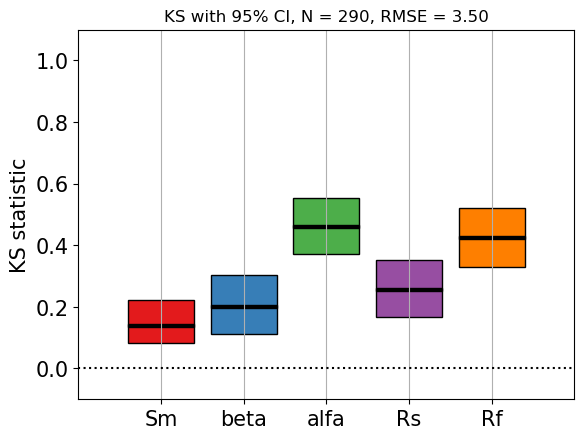

In [12]:
alfa = 0.05 # Significance level for the confidence intervals estimated by
# bootstrapping (default value is 0.05)
mvd_m, mvd_lb, mvd_ub = aggregate_boot(mvd, alfa=alfa) # shape (M,)

# The sensitivity indices with their 95% confidence intervals are plotted:
plt.figure()
pf.boxplot1(mvd_m, S_lb=mvd_lb, S_ub=mvd_ub, X_Labels=X_Labels, \
            Y_Label='KS statistic')
plt.title("KS with 95%% CI, N = %d" % N + ", " + Y_Label + " = %2.2f" % threshold)
plt.show()

**To do**:
- Are the sensitivity indices adequately estimated? 
- Is the sample size large enough?

Now choose the number of new samples to be added (N_new) and re-run the analysis:

In [13]:
# Choose the number of samples to be added:
N_new = 2000 # size of new samples
N2 = N_new + N # total sample size

# Add new samples:
X_N2 = AAT_sampling_extend(X, distr_fun, distr_par, N2)

AAT_sampling_extend allows to extend an existing sample by choosing additional samples that maximise the spread in the input space X_N2 is the extended sample (it includes the already evaluated samples 'X' and the new ones)

In [14]:
# Check the shape is X_N2:
print(X_N2.shape)

# Extract new samples:
X_new = X_N2[N:N2, :]
# Check the shape of X_new:
print(X_new.shape) 

(2290, 5)
(2000, 5)


Compute the output metrics with new sample size:

In [15]:
# Execute the model against the new inputs samples (WARNING: it may take
# some time to run this line):
QQ_new = model_execution(HyMod.hymod_sim, X_new, rain, evap)

# Aggregate time series into various scalar output metric(s):
YY_new = np.nan * np.ones((N_new, 2))
YY_new[:, 0] = RMSE(QQ_new[:, warmup:365], flow[warmup:365])
YY_new[:, 1] = BIAS(QQ_new[:, warmup:365], flow[warmup:365])

# Combine old and new output samples:
YY_N2 = np.concatenate((YY, YY_new))

# Select the output metric to be analysed (uncomment option you want to view):
Y_N2 = YY_N2[:, 0]; Y_Label = 'RMSE' # RMSE
# Y_N2 = YY_N2[:, 1]; Y_Label = 'BIAS' # BIAS

Use the function RSA_indices_thres to split into behavioural (Y<threshold) and non-behavioural (Y>threshold) sample and calculate sensitivity indices with bootstrapping (WARNING: it may take some time to run this line):

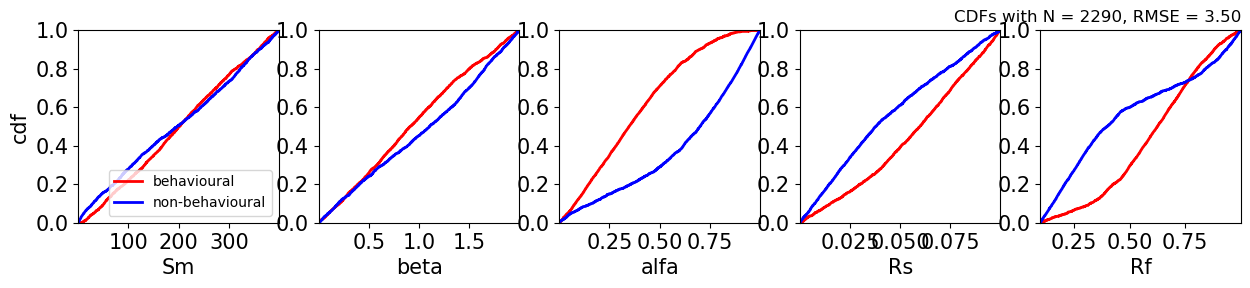

In [16]:
mvd_N2, _, _, idxb_N2 = RSA_tr.RSA_indices_thres(X_N2, Y_N2, threshold, Nboot=Nboot)
# mvd_N2 has shape (Nboot, M)

# Plot CDFs of behavioural and non-behavioural input samples:
RSA_tr.RSA_plot_thres(X_N2, idxb_N2, X_Labels=X_Labels)
plt.title("CDFs with N = %d" % N2 + ', ' + Y_Label + " = %2.2f" % threshold, \
          loc='right')
hfig_cdfs = plt.gcf() # get figure handle
hfig_cdfs.set_size_inches(15, 2.5) # set width and height
plt.show()

Compute mean and confidence intervals of the sensitivity indices (mvd, maximum vertical distance or KS statistics) across the bootstrap resamples:

Value of the bootstrap mean of the KS statistics between the two CDFs of the inputs: [0.0803883  0.13335112 0.44935983 0.25164801 0.35353943]


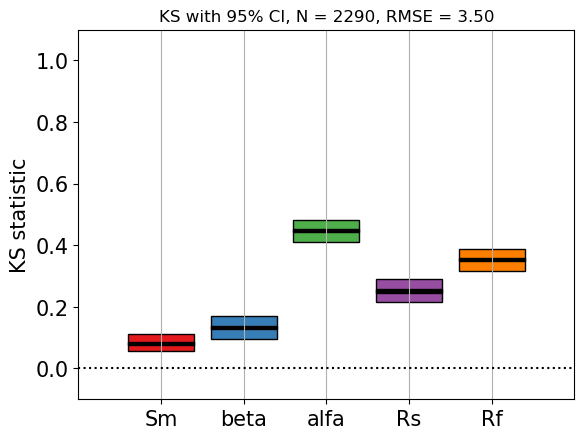

In [17]:
mvd_N2_m, mvd_N2_lb, mvd_N2_ub = aggregate_boot(mvd_N2, alfa=alfa) # shape (M,)

# Check the bootstrap mean values of the KS statistic:
print('Value of the bootstrap mean of the KS statistics between the two CDFs of the inputs: ' + str(mvd_N2_m))

# Plot the sensitivity indices with their 95% confidence intervals:
plt.figure()
pf.boxplot1(mvd_N2_m, S_lb=mvd_N2_lb, S_ub=mvd_N2_ub, X_Labels=X_Labels, \
            Y_Label='KS statistic')
plt.title("KS with 95%% CI, N = %d" % N2 + ', ' + Y_Label + " = %2.2f" % threshold)
plt.show()

**To do**:
- Has the ranking of the parameters changed?
- Is the sample size large enough now?
- How do the KS values you obtained compare to the results of the other participants?

Repeat computations using an increasing number of samples to assess convergence (WARNING: it may take some time to run this line):

In [18]:
NN = np.array([150, 300, 500, 1000, 1500, 2150]) # increasing sample sizes
Nboot = 100 # Number of resamples used for bootstrapping (suggested value 
# is 100 for the purpose of this exercise to  limit computational time, but 
# the recommended value for a rigorous analysis is 1000)
mvd_cvg, _, _ = RSA_tr.RSA_convergence_thres(X_N2, Y_N2, NN, threshold, Nboot=Nboot)
# mvd, spread and irr have shape (Nboot, M)

Compute mean and confidence intervals of the sensitivity indices across the bootstrap resamples:

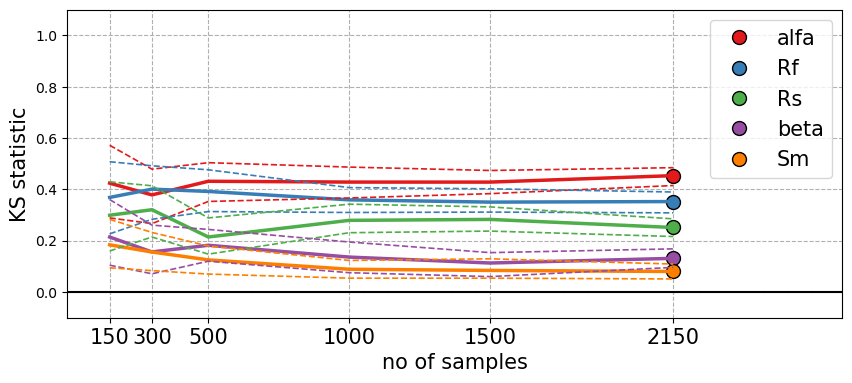

In [19]:
mvd_cvg_m, mvd_cvg_lb, mvd_cvg_ub = aggregate_boot(mvd_cvg) # shape (R,M)
# Plot the sensitivity measures as a function of the number of samples:
plt.figure()
pf.plot_convergence(mvd_cvg_m, NN, mvd_cvg_lb, mvd_cvg_ub, X_Label='no of samples',
                    Y_Label='KS statistic', labelinput=X_Labels)
hfig_cdfs = plt.gcf() # get figure handle
hfig_cdfs.set_size_inches(10, 4) # set width and height 
plt.show()

**To do**:
- Has convergence been reached? Why?

###  3.4 Assess the effect of the definition of the input factors' space of variability
In this section we assess the effect of the input (parameter) ranges. This requires new model executions (WARNING: it may take some time to run this line).

In [20]:
# Old input factors' ranges:
#xmin = [0, 0, 0, 0, 0.1] # Parameter ranges (lower bound)
#xmax = [400, 2, 1, 0.1, 1] # Parameter ranges (upper bound)

In [21]:
Sm_widget    = IntRangeSlider(  min = 0,   max = 800)
beta_widget  = FloatRangeSlider(min = 0,   max = 4)
alpha_widget = FloatRangeSlider(min = 0,   max = 0.5)
Rs_widget    = FloatRangeSlider(min = 0,   max = 0.4, value = (0,0.35))
Rf_widget    = FloatRangeSlider(min = 0.4, max = 1  , value = (0.5,1))

def input_range_function(Sm,beta,alpha,Rs, Rf):
    xmin2 = [Sm[0], beta[0], alpha[0], Rs[0], Rf[0]] # Parameter ranges (lower bound)
    xmax2 = [Sm[1], beta[1], alpha[1], Rs[1], Rf[1]] # Parameter ranges (upper bound)
    
    # The shape parameters of the uniform distribution are the lower limit and the
    # difference between lower and upper limits:
    distr_par2 = [np.nan] * M
    for i in range(M):
        distr_par2[i] = [xmin2[i], xmax2[i] - xmin2[i]]

    # Sample input factors' space using the larger sample size N2:
    X_P2 = AAT_sampling(samp_strat, M, distr_fun, distr_par2, N2)

    # Execute the model:
    QQ_P2 = model_execution(HyMod.hymod_sim, X_P2, rain, evap)

    # Aggregate time series into various scalar output metric(s):
    YY_P2 = np.nan * np.ones((N2, 2))
    YY_P2[:, 0] = RMSE(QQ_P2[:, warmup:365], flow[warmup:365])
    YY_P2[:, 1] = BIAS(QQ_P2[:, warmup:365], flow[warmup:365])

    # Select the output metric to be analysed (uncomment option you want to view):
    Y_P2 = YY_P2[:, 0]; Y_Label = 'RMSE' # RMSE
    # Y_P2 = YY_P2[:, 1]; Y_Label = 'BIAS' # BIAS
    
    # Define the threshold:
    threshold = 3.5

    # Use the function RSA_indices_thres to split into behavioural (Y<threshold)
    # and non-behavioural (Y>threshold) sample and calculate sensitivity indices
    # with bootstrapping (WARNING: it may take some time to run this line):
    mvd_P2, _, _, idxb_P2 = RSA_tr.RSA_indices_thres(X_P2, Y_P2, threshold, Nboot=Nboot)
    # mvd_N2 has shape (Nboot, M)

    # Visualize the scatter plots:
    # Old parameterisation:
    plt.figure()
    pf.scatter_plots(X_N2, Y_N2, Y_Label=Y_Label, X_Labels=X_Labels, idx=idxb_N2)
    plt.title("Scatter plots with old parameterisation with N = %d" % N2 + ', ' + Y_Label  + " = %2.2f" % threshold, \
              loc='right')
    hfig_scat = plt.gcf() # get figure handle
    hfig_scat.set_size_inches(15, 2.5) # set width and height
    plt.show()
    # New parameterisation   : 
    plt.figure()
    pf.scatter_plots(X_P2, Y_P2, Y_Label=Y_Label, X_Labels=X_Labels, idx=idxb_P2)
    plt.title("Scatter plots with new parameterisation with N = %d" % N2 + ', ' + Y_Label  + " = %2.2f" % threshold, \
              loc='right')
    hfig_scat = plt.gcf() # get figure handle
    hfig_scat.set_size_inches(15, 2.5) # set width and height
    plt.show()
    # (red = behavioural, blue = non-behavioural)

    # Plot CDFs of behavioural and non-behavioural input samples:
    RSA_tr.RSA_plot_thres(X_P2, idxb_P2, X_Labels=X_Labels)
    plt.title("CDFs with new parameterisation, N = %d" % N2 + ', ' + Y_Label + " = %2.2f" % threshold, \
              loc='right')
    hfig_cdfs = plt.gcf() # get figure handle
    hfig_cdfs.set_size_inches(15, 2.5) # set width and height
    plt.show()
    # (red = behavioural, blue = non-behavioural)

    # Compute mean and confidence intervals of the sensitivity indices (mvd,
    # maximum vertical distance or KS statistics) across the bootstrap resamples:
    mvd_P2_m, mvd_P2_lb, mvd_P2_ub = aggregate_boot(mvd_P2, alfa=alfa) # shape (M,)

    # Plot the sensitivity indices with their 95% confidence intervals:
    plt.figure()
    pf.boxplot1(mvd_P2_m, S_lb=mvd_P2_lb, S_ub=mvd_P2_ub, X_Labels=X_Labels, \
                Y_Label='KS statistic')
    plt.title("KS with 95%% CI, new par, N = %d" % N2 + ', ' + Y_Label + " = %2.2f" % threshold)
    plt.show()

interact(input_range_function,Sm = Sm_widget, beta = beta_widget, alpha = alpha_widget, Rs = Rs_widget, Rf = Rf_widget,
         continuous_update=False);

interactive(children=(IntRangeSlider(value=(200, 600), description='Sm', max=800), FloatRangeSlider(value=(1.0…

**To do**:
- Is the sample size large enough?
- How have the sensitivity indices changed by changing the range of variability?

## 4. Regional Sensitivity Analysis based on grouping
In this section, we assess the sensitivity using the RSA method based on  grouping. This variant does not require the definition of a single threshold on the output value. It consists of splitting the input factor sample into a given number of groups (e.g. ten) according to the associated output value. 

In our application, we use ten intervals of increasing output value, designed so to have an equal number of data points in each group. The corresponding ten CDFs are then derived for each input factor.

We can apply this method to the input-output sample that we have already created.

In [22]:
# Select the output metric to be analysed (uncomment option you want to view):
Y_N2 = YY_N2[:, 0]; Y_Label = 'RMSE' # RMSE
# Y_N2 = YY_N2[:, 1]; Y_Label = 'BIAS' # BIAS

# Set number of groups:
ngroup = 10 
# Perform RSA based on grouping:
_, _, _, _, _, _, idx_gp, Yk = RSA_gp.RSA_indices_groups(X_N2, Y_N2, ngroup=ngroup)
# idx_gp: indices of the ten groups
# Yk: range of values of the output
    
# Look at the range of values of the output in the ten groups:
print('Range of values of the output in the ten groups:\n' + str(Yk))

Range of values of the output in the ten groups:
[2.25564557 2.89768186 3.06938366 3.21372942 3.35900207 3.49658526
 3.64926882 3.78676323 3.96698958 4.25386899 9.71840952]


Plot parameter CDFs corresponding to the ten groups:

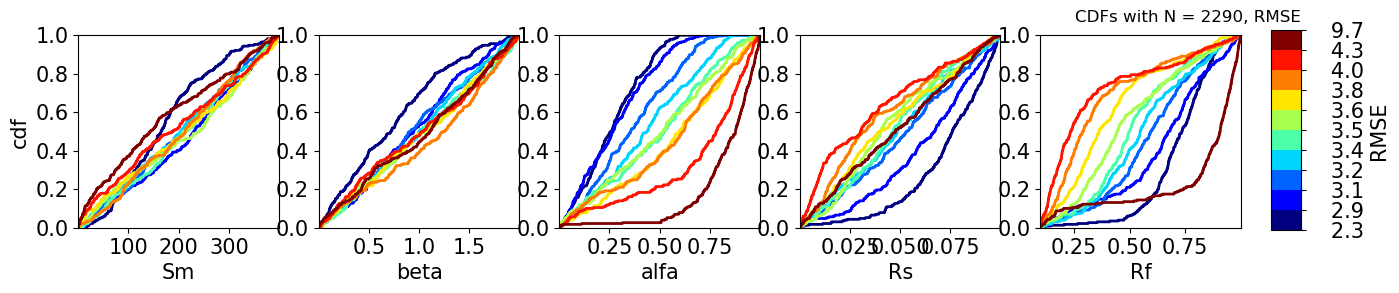

In [23]:
RSA_gp.RSA_plot_groups(X_N2, idx_gp, Yk, X_Labels=X_Labels, legend_title=Y_Label)
plt.title("CDFs with N = %d" % N2 + ', ' + Y_Label, loc='right')
hfig_cdfs = plt.gcf() # get figure handle
hfig_cdfs.set_size_inches(15, 2.5) # set width and height
plt.show()

**To do**: 
- From the CDF plots, which parameter would you say is most influential? Why?
- Are the results of RSA based on grouping consistent with the results of RSA based on threshold?
- Which additional information is provided by RSA based on grouping?

Here we only performed a visual analysis of the ten CDFs, but sensitivity indices could also be computed based on the KS statistic.

**References**:

Boyle, D. (2001). Multicriteria calibration of hydrological models. PhD thesis. 
University of Arizona, Tucson.

Noacco et al. (2019). Matlab/R workflows to assess critical choices in
Global Sensitivity Analysis using the SAFE toolbox. MethodsX. 6. 2258-2280.

Pianosi et al. (2015). A Matlab toolbox for Global Sensitivity Analysis.
Environmental Modelling and Software. 70. 80-85.

Pianosi et al. (2016). Sensitivity analysis of environmental models:
A systematic review with practical workflow. Environmental Modelling and
Software. 79. 214-232.

Saltelli et al. (2008). Global Sensitivity Analysis, The Primer, John Wiley
Sons. Ltd. Chichester, UK.

Sarrazin et al. (2016). Global Sensitivity Analysis of environmental models:
Convergence and validation. Environmental Modelling and Software. 79.
135-162.

Sorooshian at al. (1983). Evaluation of maximum likelihood parameter
estimation techniques for conceptual rainfall-runoff models: Influence of
calibration data variability and length on model credibility. Water Resour.
Res. 19. 251-259.

Spear and Hornberger (1980). Eutrophication in peel inlet e II.
Identification of critical uncertainties via generalized sensitivity analysis.
Water Research. 14(1). 43-49.

Wagener et al. (2001). A framework for development and application of
hydrological models. Hydrol. Earth Syst. Sci.. 5. 13-26.

Wagener and Pianosi (2019). What has Global Sensitivity Analysis ever done for 
us? A systematic review to support scientific advancement and to inform policy-
making in earth system modelling. Earth-Science Reviews. 194. 1-18.

Young et al. (1978). Modelling badly defined systems: some further thoughts.
In: Proceedings SIMSIG Conference. Canberra. 24-32.